In [1]:
import torch.nn as nn 
from torch.distributions import MultivariateNormal, Categorical
from torch.optim.lr_scheduler import ReduceLROnPlateau
from numpy.typing import NDArray
import torch.nn.functional as F
import gymnasium as gym
import gym_agent as ga
from gym_agent import OnPolicyAgent
import torch
import numpy as np
from typing import *
import torch.optim as optim
from tqdm.notebook import tqdm_notebook as tqdm
import utils

import better_car_racing
ObsType = TypeVar("ObsType")
ActType = TypeVar("ActType")

In [2]:
class ConvBn(nn.Module):
	'''
	Convolution + BatchNorm + ReLu (+ MaxPool)

	keeping the size of input, if Maxpool, reduce the size by half
	'''
	def __init__(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, pool=False) -> None:
		'''
		Convolution + BatchNorm + ReLu (+ MaxPool)

		keeping the size of input, if Maxpool, reduce the size by half
		'''
		super().__init__()
		self.Conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
		self.Bn = nn.BatchNorm2d(out_channels)
		self.act = nn.ReLU()
		
		if pool:
			self.pool = nn.MaxPool2d(2)
		else:
			self.pool = nn.Identity()

	def forward(self, X: torch.Tensor):
		out = self.Conv(X)
		out = self.Bn(out)
		out = self.act(out)
		out = self.pool(out)
		return out

In [3]:
class ConvNetwork(nn.Module):
    def __init__(self, in_channels: int, n_vector: int, n_actions: int, filters: list[int] = [16, 32, 64], fc: list[int] = [256]) -> None:
        super().__init__()

        self.initial = ConvBn(in_channels, filters[0], 8, 4, 2)

        self.conv = nn.Sequential()

        for i in range(len(filters)-1):
            self.conv.append(ConvBn(filters[i], filters[i+1], pool=True))
        
        self.conv.append(nn.AdaptiveMaxPool2d((16, 16)))

        self.conv.append(nn.Flatten())

        self.fcs = nn.Sequential(
            nn.Linear(16*16*filters[-1] + n_vector, fc[0]),
            nn.ReLU(),
            nn.Linear(fc[0], n_actions)
        )

    def forward(self, state: dict[str, torch.Tensor]) -> torch.Tensor:
        image = state['image']
        vector = state['vector']

        image_encoded = self.initial(image)
        image_encoded = self.conv(image_encoded)

        inp_vector = torch.cat([image_encoded, vector], dim=1)

        return self.fcs(inp_vector)

In [4]:
class CarRacingPolicy(nn.Module):
    def __init__(self, in_channels: int, n_vector: int, n_actions: int, filters: list[int], fcs: list[int], optimizer: Type[optim.Optimizer] = optim.Adam, lr_actor: float = 5e-4, lr_critic: float = 5e-4, optimizer_kwargs: dict = None):
        super().__init__()  
        self.actor = ConvNetwork(in_channels, n_vector, n_actions, filters, fcs)
        self.critic = ConvNetwork(in_channels, n_vector, 1, filters, fcs + [n_actions])

        if optimizer_kwargs is None:
            optimizer_kwargs = {}
        
        self.actor_optimizer = optimizer(self.actor.parameters(),  lr=lr_actor, **optimizer_kwargs)
        self.critic_optimizer = optimizer(self.critic.parameters(), lr=lr_critic, **optimizer_kwargs)

    

In [5]:
from gym_agent import RolloutBuffer
from numpy.typing import NDArray
from gymnasium import spaces
import numpy as np 
from typing import NamedTuple

class TestRolloutBufferSamples(NamedTuple):
    observations: torch.Tensor | dict[str, torch.Tensor]
    actions: torch.Tensor | dict[str, torch.Tensor]
    rewards: torch.Tensor
    log_prob: torch.Tensor
    advantages: torch.Tensor
    returns: torch.Tensor
    dynamic_scaling: torch.Tensor

class TestRolloutBuffer(RolloutBuffer):
    observations: NDArray | dict[str, NDArray]
    actions: NDArray | dict[str, NDArray]
    rewards: NDArray

    advantages: NDArray
    returns: NDArray
    log_probs: NDArray
    values: NDArray
    dynamic_scaling: NDArray

    def __init__(
            self, 
            buffer_size: int, 
            observation_space: spaces.Space, 
            action_space: spaces.Space, 
            gamma = 0.99,
            gae_lambda = 0.95,
            device = "auto", 
            n_envs: int = 1, 
            seed: int = None,
            dynamic_scaling_max = 900, 
            test = False
        ):
        super().__init__(buffer_size, observation_space, action_space, gamma, gae_lambda, device, n_envs, seed)

        self.dynamic_scaling_max = dynamic_scaling_max

        self.test = test
    
    def calc_advantages_and_returns(self, last_values: NDArray[np.float32], last_terminals: NDArray[np.bool_]) -> None:
        if self.processed:
            raise ValueError("Cannot calculate advantages and returns after processing the buffer.")
                
        def _calc_advantages_and_returns(env):
            if self.gae_lambda == 1:
                # No GAE, returns are just discounted rewards
                T = self.end_mem_pos[env]
                advantages = np.zeros(T, dtype=np.float32)
                returns = np.zeros(T, dtype=np.float32)
                next_return = 0
                for t in reversed(range(T)):
                    next_return = self.rewards[t][env] + self.gamma * next_return
                    returns[t] = next_return

                advantages = returns - self.values[:T, env]


                return advantages, returns
                
            T = self.end_mem_pos[env]
            advantages = np.zeros(T, dtype=np.float32)
            last_gae_lambda = 0

            for t in reversed(range(T)):
                if t == T - 1:
                    next_non_terminal = 1.0 - last_terminals[env]
                    next_values = last_values[env]
                else:
                    next_non_terminal = 1.0
                    next_values = self.values[t + 1][env]

                delta = self.rewards[t][env] + next_non_terminal * self.gamma * next_values - self.values[t][env]
                last_gae_lambda = delta + next_non_terminal*self.gamma * self.gae_lambda *  last_gae_lambda

                advantages[t] = last_gae_lambda.item() 
            
            returns = advantages + self.values[:T, env]

            return advantages, returns

        for env in range(self.n_envs):
            advantages , returns = _calc_advantages_and_returns(env)
            self.advantages[:self.end_mem_pos[env], env] = advantages
            self.returns[:self.end_mem_pos[env], env] = returns
    
    def calc_dynamic_scaling(self, returns, batch=0) -> NDArray: 
        if not batch: 
            batch = returns.shape[0]
        
        if isinstance(returns, torch.Tensor):
            returns = returns.cpu().detach().numpy()
        
        # print(returns.shape)
        temp = np.mean(returns[:batch])
        dynamic_scaling = temp / self.dynamic_scaling_max
        return np.abs(dynamic_scaling)

In [6]:
from gym_agent.agent.buffers import RolloutBuffer
from gym_agent.agent.agent_callbacks import Callbacks
from gym_agent import OnPolicyAgent

from numpy.typing import NDArray
from torch.distributions import MultivariateNormal, Categorical
import torch.nn.functional as F
from typing import *
ObsType = TypeVar("ObsType")
ActType = TypeVar("ActType")
class PPOAgent(OnPolicyAgent): 
    def __init__(self,
            policy: nn.Module,
            env: ga.Env,
            batch_size: int = 512,
            device: str = 'cpu',
            is_continuous=False,
            seed = None,
            **kwargs) -> None: 
        # Explicitly pass `on_policy` and `buffer_size`
        
        self.is_continuous = is_continuous
        
        self.forward_action = 3
        self.n_envs = 1
        self.last_forward = np.array([0]*self.n_envs)

        self.lr_critic = kwargs.get('lr_critic', 5e-4)
        self.lr_actor = kwargs.get('lr_actor', 5e-4)
        self.gamma = kwargs.get('gamma', 0.99) 
        self.action_std = kwargs.get('action_std', 0.6) 
        self.eps_clip = kwargs.get('eps_clip', 0.2) 
        self.clip_vf = kwargs.get('clip_vf', 10)
        self.gae_lamda = kwargs.get('lamda', 0.9)
        self.iterations = kwargs.get('k', 5)
        self.coef_entropy = kwargs.get('coef_entropy', 0.01)
        self.coef_crit = kwargs.get('coef_crit', 0.5)
        self.max_norm = kwargs.get('max_norm', None)
        self.force_forward = kwargs.get('force_forward', False)
        
        super().__init__(policy, env, self.gamma, self.gae_lamda, buffer_size=int(10000),batch_size=batch_size, device=device, seed=seed)
        self.add_optimizer('actor', self.policy.actor_optimizer)
        self.add_optimizer('critic', self.policy.critic_optimizer)

        self.loss_arr = []
        # self.actor_scheduler = CosineAnnealingLR(self.policy.actor_optimizer, T_max=100)
        # self.critic_scheduler = CosineAnnealingLR(self.policy.critic_optimizer, T_max=100)

        self.set_action_var(self.action_std)


    def set_action_var(self, new_action_std):
        self.action_std = new_action_std 
        self.action_var = self.action_std**2
    @torch.no_grad()
    def predict(self, state: NDArray | dict[str, NDArray], deterministic: bool = True) -> ActType:

        self.policy.actor.eval()
        
        _state = {}
        for key, value in state.items(): 
            _state[key] = torch.from_numpy(value).float().to(self.device)
        action_probs = F.softmax(self.policy.actor(_state), dim = 1)
        if deterministic:
            action = action_probs.argmax().unsqueeze(0).detach().cpu().numpy()
            print(action)
            return action
        else:
            if self.is_continuous:
                cov_mat = torch.diag(torch.tensor([self.action_var] * action_probs.shape[-1])).to(self.device)
                dist = MultivariateNormal(action_probs, cov_mat)
            
            else: 
                dist = Categorical(action_probs)
            action = dist.sample()
            return action.detach().cpu().numpy()
            
    def evaluate(self, state, deterministic: bool = False) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        self.policy.actor.eval()
        self.policy.critic.eval() 
        _state = {}
        for key, value in state.items(): 
            _state[key] = torch.from_numpy(value).float().to(self.device)
        
        # print(state.shape)
        
        logits = self.policy.actor(_state)
        # print(logits)
        action_probs = F.softmax(logits, dim = 1)
        print('Action probs max: ', action_probs)
        action_probs = action_probs
        if deterministic:
            return action_probs.argmax().detach().cpu().numpy()
        else:
            if self.is_continuous:
                cov_mat = torch.diag(torch.tensor([self.action_var] * action_probs.shape[-1])).to(self.device)
                dist = MultivariateNormal(action_probs, cov_mat)
            
            else: 
                dist = Categorical(action_probs)
        
        action = dist.sample()
        logprobs = dist.log_prob(action)
        value = self.policy.critic(_state)
        
        # If 10 step, the car is stuck, force it to go forward
        if self.force_forward: 
            if not deterministic and self.mean_scores and self.mean_scores[-1] < -10:
                for i in range(self.n_envs):
                    if action[i] != self.forward_action:
                        self.last_forward[i] += 1
                    else:
                        self.last_forward[i] = 0
                for i in range(self.n_envs):
                    if self.last_forward[i] > 10:
                            # print('execute')
                            action[i] = self.forward_action
                            self.last_forward[i] = 0


        # print('values shape: ', value.shape, 'log_probs shape: ',logprobs.shape,'action shape: ', action.shape)
        # print('Action: ', action)
        return action.detach().cpu().numpy(), value.detach().cpu().numpy(), logprobs.detach().cpu().numpy()
    
    def evaluate_actions(self, state, action) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        _state = {}
        for key, value in state.items(): 
            _state[key] = (value).float().to(self.device)
        self.policy.actor.eval()
        self.policy.critic.eval()
        
        # print(state.shape)
        probs = F.softmax(self.policy.actor(_state), dim = 1)
        # print('probs shape: ', probs.shape)
        values = self.policy.critic(_state)
        if self.is_continuous:
            dist = MultivariateNormal(probs, self.action_var)
        else:
            dist = Categorical(probs)

        log_probs = dist.log_prob(action)

        entropy = dist.entropy()

        # print('values shape: ', values.shape, 'log_probs shape: ',log_probs.shape,'entropy shape: ', entropy.shape)
        return values, log_probs, entropy
    
   
    def learn(self, memory: RolloutBuffer, dynamic_scaling = None) -> None:
        for _ in range(self.iterations):
            for rollout in memory.get(self.batch_size): 
                # print(f"State: {rollout.observations}")
                if not dynamic_scaling: 
                    dynamic_scaling = 1
                log_prob, state_values, dist_entropy = self.evaluate_actions(rollout.observations, rollout.actions)
                dist_entropy = -dist_entropy

                self.policy.actor.train()
                self.policy.critic.train()

                advantages = (rollout.advantages - rollout.advantages.mean()) / (rollout.advantages.std() + 1e-8)
                returns = (rollout.returns - rollout.returns.mean()) / (rollout.returns.std() + 1e-8)

                ratio = torch.exp(log_prob - rollout.log_prob)
                surr1 = ratio * advantages
                surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantages

                # Calculate actor and critic losses
                actor_loss = -torch.min(surr1, surr2)

                values_pred = state_values

                values_pred = rollout.values + torch.clamp(
                        state_values - rollout.values, -self.clip_vf, self.clip_vf
                    )  # test of clamping critic value 
                critic_loss = F.smooth_l1_loss(returns, values_pred)

                # v_clipped = torch.clamp(state_values, rollout.values - self.clip_vf, rollout.values + self.clip_vf)
                # unclipped_v_loss = F.smooth_l1_loss(state_values, returns)
                # v_clipped_loss = F.smooth_l1_loss(v_clipped, returns)
                # critic_loss = torch.max(unclipped_v_loss, v_clipped_loss).mean()
                
                loss = (actor_loss + self.coef_crit * critic_loss + self.coef_entropy * dynamic_scaling * dist_entropy).mean()

                self.policy.actor_optimizer.zero_grad()
                self.policy.critic_optimizer.zero_grad()
                loss.backward()

                # Calculate gradient norm
                # total_norm = 0.0
                # for param in self.policy.parameters():
                #     if param.grad is not None:
                #         param_norm = param.grad.data.norm(2)  # L2 norm
                #         total_norm += param_norm.item() ** 2
                # total_norm = total_norm ** 0.5
                # print(f"Gradient Norm: {total_norm:.4f}")

                # Gradient clipping
                if self.max_norm is not None:
                    torch.nn.utils.clip_grad_norm_(self.policy.actor.parameters(), max_norm=self.max_norm)
                    torch.nn.utils.clip_grad_norm_(self.policy.critic.parameters(), max_norm=self.max_norm)
                self.policy.actor_optimizer.step()
                self.policy.critic_optimizer.step()


    def step(self, observation: NDArray | dict[str, NDArray], action: NDArray | dict[str, NDArray], reward: NDArray, value: NDArray, log_prob: NDArray, terminal: NDArray[np.bool_]) -> None:
        self.memory.add(observation, action, reward, value, log_prob, terminal)

    def train_on_episode(self, deterministic: bool, callbacks: Type[Callbacks] = None):
        if callbacks is None:
            callbacks = Callbacks(self)

        done = False
        score = 0
        timesteps = 0
        callbacks.on_episode_begin()

        obs = self.envs.reset()[0]
        self.reset()

        while not done:
            action, value, log_prob = self.evaluate(obs, deterministic)
            next_obs, reward, terminal, truncated, info = self.envs.step(action)

            done = (terminal | truncated).all()

            self.step(obs, action, reward, value, log_prob, terminal)

            score += reward.mean()
            obs = next_obs
            timesteps += 1
        
        self.memory.calc_advantages_and_returns(value, terminal)
        dynamic_scaling = None
        if isinstance(self.memory, TestRolloutBuffer):
            
            dynamic_scaling = self.memory.calc_dynamic_scaling(self.memory.returns, self.batch_size)

        callbacks.on_learn_begin()
        self.learn(self.memory, dynamic_scaling = dynamic_scaling)
        callbacks.on_learn_end()
        self.memory.reset()

        callbacks.on_episode_end()

        return score, timesteps
            
            

In [7]:
# Set env
n_games = 1000
max_t = 1500
n_envs = 1
chkpt_dir = 'checkpoints/BetterCarRacing-v0/CNN_PPO'

env_id = "BetterCarRacing-v0"

seed = 110404

die_if_grass = True

In [8]:
utils.set_random_seed(seed)

Setting seeds ...... 



In [9]:
reward_threshold = 900

### Transform

In [10]:
class StateTfm(ga.Transform):
    def __init__(self, n_frame=4):
        super().__init__()

        self.observation_space = gym.spaces.Dict({
            'image': gym.spaces.Box(low=0, high=1, shape=(n_frame, 96, 96), dtype=np.float32),
            'vector': gym.spaces.Box(low=-np.inf, high=np.inf, shape=(7, ), dtype=np.float32),
        })

        self.n_frame = n_frame

        self.frames = {'image': np.zeros((self.n_frame, 96, 96), dtype=np.float32), 'vector': np.zeros((7, ), dtype=np.float32)}

        self.start = False

    def __call__(self, observation: dict[str, np.ndarray]) -> np.ndarray:
        image = observation['image'].astype(np.float32).transpose([2, 0, 1]) # n_envs, 4, 96, 96
        r, g, b = image[0], image[1], image[2]
        gray_image = 0.2989 * r + 0.5870 * g + 0.1140 * b

        vels = observation['vels'].astype(np.float32)
        # res = np.concatenate([rays, vels], axis=-1)

        if self.start:
            self.frames['image'][0] = gray_image
            self.frames['image'] = np.roll(self.frames['image'], shift=-1, axis=0)
            
        else:
            for i in range(self.n_frame):
                self.frames['image'][i] = gray_image

        self.frames['vector'] = vels

        self.start = True

        return self.frames

    def reset(self, **kwargs):
        self.frames = {'image': np.zeros((self.n_frame, 96, 96), dtype=np.float32), 'vector': np.zeros((7, ), dtype=np.float32)}

        self.start = False

In [11]:
import gymnasium as gym
class ActionTfm(ga.Transform):
    def __init__(self):
        super().__init__()

        self.action_space = gym.spaces.Discrete(4)

    def __call__(self, action: int) -> int:
        return action + 1
        # return action

### Train

In [12]:
env = ga.make(env_id, observation_transform=StateTfm(), continuous=False, die_if_grass = die_if_grass, random_direction=False)

env.add_wrapper(utils.SkipFrame, skip=4)

In [13]:
agent = PPOAgent(
    policy=CarRacingPolicy(4, 7, 5, filters=[16, 32, 64], fcs=[256], lr_actor = 5e-5, lr_critic = 1e-4, optimizer = optim.Adam
                            ).apply(utils.init_weights('xavier')),
    env = env,
    k = 10,
    coef_crit = 0.5,
    coef_entropy = 0.1,
    batch_size = None,
    device = 'cuda',
    gamma = 0.99, 
    lamda = 0.95,
    eps_clip = 0.2,
    clip_vf = 10,
    max_norm = None,
    force_forward = True,
    early_stopping = True
)

In [14]:
agent.memory = TestRolloutBuffer(
    buffer_size = 10000, 
    observation_space = agent.dummy_env.observation_space, 
    action_space = agent.dummy_env.action_space, 
    device = agent.device, 
    n_envs = agent.n_envs, 
    gamma = 0.99, 
    gae_lambda = 0.95, 
    seed = agent.seed, 
    dynamic_scaling_max = reward_threshold,
    test = False
    )

# agent.memory.action_shape = 5

In [15]:
# agent.load(chkpt_dir, '22600')

In [16]:
agent.fit(n_games=40000, deterministic=False, save_best=True, save_every=100, save_dir=chkpt_dir, progress_bar=tqdm)

  0%|          | 0/40000 [00:00<?, ?it/s]

Action probs max:  tensor([[0.0227, 0.0134, 0.9408, 0.0171, 0.0059]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Action probs max:  tensor([[0.0228, 0.0134, 0.9408, 0.0171, 0.0059]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Action probs max:  tensor([[0.0228, 0.0134, 0.9408, 0.0171, 0.0059]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Action probs max:  tensor([[0.0227, 0.0134, 0.9408, 0.0171, 0.0059]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Action probs max:  tensor([[0.0228, 0.0134, 0.9407, 0.0172, 0.0059]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Action probs max:  tensor([[0.0228, 0.0134, 0.9406, 0.0172, 0.0059]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Action probs max:  tensor([[0.0228, 0.0134, 0.9407, 0.0172, 0.0059]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Action probs max:  tensor([[0.0228, 0.0134, 0.9407, 0.0172, 0.0059]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
Action probs max:  tenso

KeyboardInterrupt: 

In [ ]:
print(agent.memory.action_shape)

()


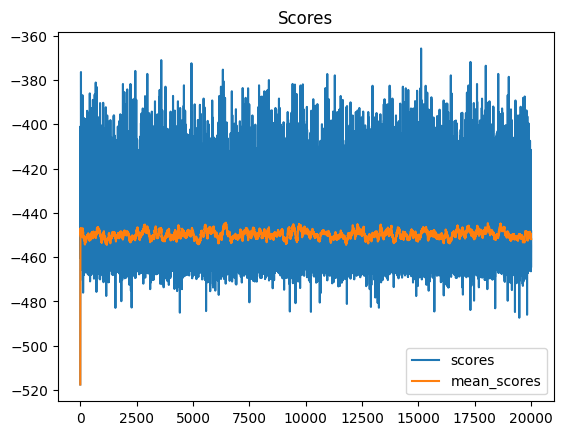

In [ ]:
agent.plot_scores()

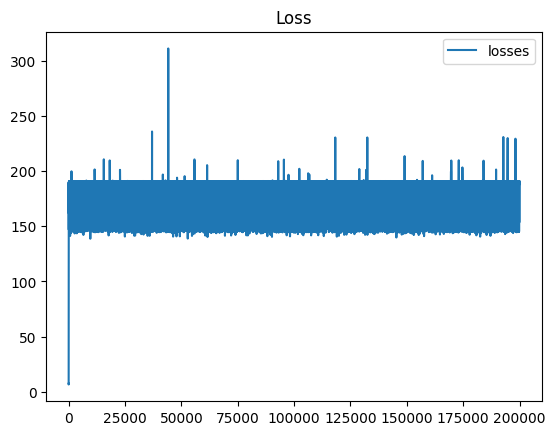

In [ ]:
import matplotlib.pyplot as plt
plt.plot(agent.loss_arr, label='losses')
plt.title("Loss")

plt.legend()

In [ ]:
env = ga.make(env_id, render_mode = 'human', observation_transform=StateTfm(), continuous=False, die_if_grass = True, lap_complete_percent = 1)
env.add_wrapper(utils.SkipFrame, skip=4)
# agent.load(chkpt_dir, "best")
agent.play(env, stop_if_truncated=True)

[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


np.float64(-518.2432432432432)